Ball Tree
https://www.youtube.com/watch?v=E1_WCdUAtyE

- kdtree always split along an axis - this makes them very fast to query for nearest neighbors but they're not good for high diemnsions
- instead of doing PCA to find the spread, you can approximate it by
    - pick a point $p$ at random
    - find the furthest point $q$ from $p$
    - then find the furthest point $r$ from $q$
    - the vector $\vec{qr}$ is good approximation for the axis of high variance
    - this 2 step process is used at each iteration for drawing balls 

- a ball is considered a leaf node if it contains fewer than `leaf_size` points


In [1]:
from dataclasses import dataclass
from typing import List, Tuple, Optional
import math
import random
import numpy as np
from matplotlib import pyplot as plt

In [80]:
@dataclass
class BallNode:
    center: np.ndarray[float]
    radius: float
    points: np.ndarray[float]
    left: Optional['BallNode'] = None
    right: Optional['BallNode'] = None
    is_leaf: bool = False


def euclidean(a:np.ndarray, b:np.ndarray):
    return np.linalg.norm(a-b)


class BallTree:
    def __init__(self, points: np.ndarray[float], leaf_size: int = 1):
        self.balls = []
        self.leaf_size = leaf_size
        self.root = self._build(points)

    def _build(self, points: np.ndarray[float]) -> BallNode:
        
        # Compute node center and radius of points
        center = np.mean(points,axis=0)
        radius = np.max(np.linalg.norm(points - center,axis=1))

        n = len(points)
        if n <= self.leaf_size:
            self.balls.append((center,radius))
            return BallNode(center, radius, points, is_leaf=True)

        # 2-step approximation for finding axis of maximum variance
        p_a = random.choice(points) # choose a point at random
        distances_to_pa = np.linalg.norm(p_a - points, axis = 1)
        p_b = points[np.argmax(distances_to_pa)]
        distances_to_pb = np.linalg.norm(p_b - points, axis = 1)
        p_c = points[np.argmax(distances_to_pb)]

        # p_b and p_c will become the centers of two spheres
        # they are the left-child-node and the right-child-node of the parent node
        # assign points into these two spheres
        points_b, points_c = [], []
        for p in points:
            if euclidean(p, p_b) < euclidean(p, p_c): 
                points_b.append(p)
            else: 
                points_c.append(p)

        # recursively build the left and right sub-trees
        node = BallNode(center, radius, points) # the root for all these points
        node.left = self._build(points_b) # the left children of root
        node.right = self._build(points_c) # the right children of root
        self.balls.append((center,radius))
        return node

    def nearest(self, query: Tuple[float, ...]) -> Tuple[Tuple[float, ...], float]:
        best = [None, float('inf')]

        def recurse(node: BallNode):
            if node is None:
                return
            # Distance from query to the node's ball
            d_center = euclidean(query, node.center)
            if d_center - node.radius > best[1]:
                # Ball is too far away — prune
                return

            if node.is_leaf:
                # Check all points
                for p in node.points:
                    d = euclidean(query, p)
                    if d < best[1]:
                        best[0], best[1] = p, d
            else:
                # Recurse into closer child first
                d_left = euclidean(query, node.left.center)
                d_right = euclidean(query, node.right.center)
                near_child,far_child = node.left,node.right
                if d_left > d_right:
                    far_child,near_child = node.left,node.right

                recurse(near_child) 
                recurse(far_child)

        recurse(self.root)
        return best[0], best[1]


    def getBalls(self):
        return self.balls

Query: (0.5, 0.5)
Nearest neighbor: [0.37480119 0.60841519]
Distance: 0.1656


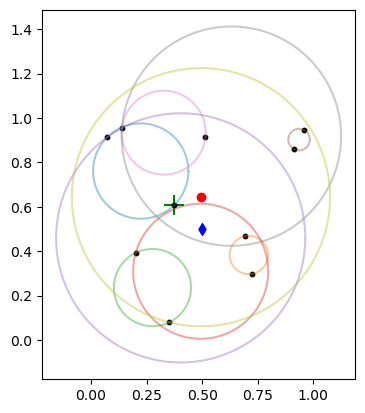

In [87]:
random.seed(0)
points = np.random.rand(10,2)

tree = BallTree(points, leaf_size=2)
query = (0.5, 0.5)

nn, dist = tree.nearest(query)
print("Query:", query)
print("Nearest neighbor:", nn)
print("Distance:", round(dist, 4))

center = np.mean(points,axis=0)
radius = np.max(np.linalg.norm(points - center,axis=1))

plt.scatter(center[0],center[1],color='red')
plt.scatter(query[0],query[1],color='blue',marker='d')
plt.scatter(nn[0],nn[1],color='green',marker='+',s=200)

plt.scatter(points[:,0],points[:,1],color='black',s=10)

# plot the circles for all of our balls
theta = np.linspace(0, 2 * np.pi, 300)
for ball in tree.balls:
    c,r = ball
    x = c[0] + r * np.cos(theta)
    y = c[1] + r * np.sin(theta)
    plt.plot(x, y, alpha=0.4)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [76]:
tree.balls[0]

(array([0.49318259, 0.53071366]), np.float64(0.5506147624461263))